<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [52]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [53]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/4.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.838168
1,0.814640
2,0.801280
3,0.803872
4,0.780264
...,...
38875,0.729952
38876,0.710640
38877,0.736008
38878,0.705272


In [54]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [55]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [56]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [57]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
#         seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [58]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [59]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [60]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [61]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.5000e-06.
smape 23.97816461211408 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 15.405606672233136 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 14.811822663861932 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 14.016130145976854 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 13.383537295345239 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 12.721833008020159 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 12.17688430503708 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 11.640952523057049 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 11.251172526189459 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 10.785968509551726 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 10.452779044685832 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 10.081892583453865 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 9.793285819543907 %
Ad

In [62]:
torch.manual_seed(42)

In [63]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [64]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 2.125676671974361 %
SMAPE 5.490328557789326 %
SMAPE 2.04346311558038 %
SMAPE 0.15747257792008895 %
SMAPE 1.6979841026477518 %
SMAPE 0.03902433108882519 %
SMAPE 0.704313503272715 %
SMAPE 1.7947943643666804 %
SMAPE 1.245188472326845 %
SMAPE 2.0917104817926884 %
SMAPE 2.5497208274900913 %
SMAPE 0.029090987597555795 %
SMAPE 3.93504928983748 %
SMAPE 2.924280511215329 %
SMAPE 2.2320011649280787 %
SMAPE 1.0447947827342432 %
SMAPE 3.7294972613453865 %
SMAPE 0.3287058652281303 %
SMAPE 0.904875697686748 %
SMAPE 2.264229974709451 %
SMAPE 0.16235140564685935 %
SMAPE 4.409714430570602 %
SMAPE 2.998850952833891 %
SMAPE 0.7917711445734311 %
SMAPE 4.482352092862129 %
SMAPE 1.6279984265565872 %
SMAPE 1.7132044788450003 %
SMAPE 0.8999834612186532 %
SMAPE 3.517540404573083 %
SMAPE 0.3514604455326662 %
SMAPE 2.4736470486968756 %
SMAPE 0.05869048788014197 %
SMAPE 0.8127928231124315 %
SMAPE 5.355266489088535 %
SMAPE 7.1021307967603216 %
SMAPE 5.836515683680773 %
SMAPE 0.98914496172074 %
SMAPE 2.649806

SMAPE 3.9667521696537733 %
SMAPE 10.475464478135109 %
SMAPE 2.9305441062897444 %
SMAPE 1.9081541378982367 %
SMAPE 0.22961715728240503 %
SMAPE 2.4900905322283506 %
SMAPE 0.41259537409132463 %
SMAPE 2.1453942535445094 %
SMAPE 4.702567655593157 %
SMAPE 0.3486452679235299 %
SMAPE 4.808121025562286 %
SMAPE 4.07144707813859 %
SMAPE 4.631968643516302 %
SMAPE 4.453576736152172 %
SMAPE 0.4549180241765498 %
SMAPE 4.4485782869160175 %
SMAPE 3.6000701561570168 %
SMAPE 0.012061091299074178 %
SMAPE 2.8899333775043488 %
SMAPE 1.358998682582751 %
SMAPE 4.49257505312562 %
SMAPE 4.371215172111988 %
SMAPE 3.386413648724556 %
SMAPE 0.9227603559008913 %
SMAPE 0.22379109968642297 %
SMAPE 1.9092522216960788 %
SMAPE 7.5836774706840515 %
SMAPE 2.0615438167005777 %
SMAPE 2.1328878281638026 %
SMAPE 0.020119854526456038 %
SMAPE 9.769551783800125 %
SMAPE 4.791980851441622 %
SMAPE 3.150753462687135 %
SMAPE 0.18346674180820344 %
SMAPE 1.0057816855428428 %
SMAPE 0.2735280387316834 %
SMAPE 0.4006101501577177 %
SMAPE 3

SMAPE 3.4873984418809414 %
SMAPE 0.7562237437814474 %
SMAPE 4.327967345714569 %
SMAPE 1.98095160163939 %
SMAPE 5.893935568630695 %
SMAPE 1.6996311750262976 %
SMAPE 7.9897042363882065 %
SMAPE 0.7655639220029116 %
SMAPE 4.504486698657274 %
SMAPE 0.3265873467316851 %
SMAPE 3.434855218976736 %
SMAPE 1.675541072152555 %
SMAPE 3.4837971180677414 %
SMAPE 1.0524501353502274 %
SMAPE 3.712722893804312 %
SMAPE 2.4531239941716194 %
SMAPE 1.2411367436870933 %
SMAPE 1.9148383848369124 %
SMAPE 2.991422351449728 %
SMAPE 0.5717221978120506 %
SMAPE 1.416771775111556 %
SMAPE 0.48279019235633314 %
SMAPE 1.9174923617392778 %
SMAPE 0.1678875303678069 %
SMAPE 1.6975452695041895 %
SMAPE 1.5043455651029944 %
SMAPE 2.891353640705347 %
SMAPE 2.756437487900257 %
SMAPE 1.7251368509605527 %
SMAPE 2.789678445085883 %
SMAPE 3.988877922296524 %
SMAPE 3.1716717984527345 %
SMAPE 4.914418749511242 %
SMAPE 1.8390062358230355 %
SMAPE 3.058886894956231 %
SMAPE 3.4259372204542156 %
SMAPE 4.970230717211962 %
SMAPE 1.730518749

SMAPE 1.3360635433346033 %
SMAPE 0.06955414164440299 %
SMAPE 1.2340290248394012 %
SMAPE 0.9384108181111515 %
SMAPE 0.20077387900641952 %
SMAPE 1.182008270174265 %
SMAPE 2.2131990417838097 %
SMAPE 0.5138436637353152 %
SMAPE 5.16406487673521 %
SMAPE 0.36839742929441854 %
SMAPE 2.1936829946935177 %
SMAPE 2.6244606878608465 %
SMAPE 2.276187052950263 %
SMAPE 4.121971048414707 %
SMAPE 1.728469993919134 %
SMAPE 5.55044374614954 %
SMAPE 0.06217866366944236 %
SMAPE 5.290228433907032 %
SMAPE 1.029147582128644 %
SMAPE 5.774435579776764 %
SMAPE 0.3598589764442295 %
SMAPE 5.457846418023109 %
SMAPE 0.179006244363336 %
SMAPE 5.828857596963644 %
SMAPE 0.6748037808574736 %
SMAPE 7.796692170202732 %
SMAPE 1.295403820462525 %
SMAPE 4.933212839066982 %
SMAPE 1.00669155549258 %
SMAPE 2.82063209079206 %
SMAPE 0.011935975197843618 %
SMAPE 3.271774353459477 %
SMAPE 0.6378468337934464 %
SMAPE 2.8327381536364555 %
SMAPE 3.4961722157895565 %
SMAPE 1.4024984873831272 %
SMAPE 3.225923588499427 %
SMAPE 0.0055748253

SMAPE 2.2927621733397245 %
SMAPE 3.1385488398373127 %
SMAPE 6.924265369772911 %
SMAPE 1.774048263207078 %
SMAPE 7.418073870241643 %
SMAPE 3.424571879208088 %
SMAPE 8.310247533023357 %
SMAPE 1.853456753306091 %
SMAPE 9.538471326231956 %
SMAPE 0.07923801304241351 %
SMAPE 6.540000878274441 %
SMAPE 5.156555067747831 %
SMAPE 2.37955853715539 %
SMAPE 4.873660888522863 %
SMAPE 3.1402905993163586 %
SMAPE 4.126405738294125 %
SMAPE 4.04279476031661 %
SMAPE 2.4093589577823877 %
SMAPE 4.84477199614048 %
SMAPE 1.748417293652892 %
SMAPE 6.508764836937189 %
SMAPE 4.070405252277851 %
SMAPE 4.74270873516798 %
SMAPE 5.77733376994729 %
SMAPE 1.581098448485136 %
SMAPE 7.036458164453506 %
SMAPE 0.33303613580756064 %
SMAPE 7.64495537430048 %
SMAPE 0.7568921821657568 %
SMAPE 11.783673502504826 %
SMAPE 0.35858956141419185 %
SMAPE 7.552321963012218 %
SMAPE 2.7180632315576077 %
SMAPE 10.447917379438877 %
SMAPE 0.025051313252447468 %
SMAPE 4.6356103755533695 %
SMAPE 3.4328069631010294 %
SMAPE 4.0633081831038 %
S

SMAPE 2.399861861951649 %
SMAPE 5.837702736258507 %
SMAPE 0.6035642252227262 %
SMAPE 4.14023376069963 %
SMAPE 3.5008537359535694 %
SMAPE 1.5118890353478491 %
SMAPE 3.936072016134858 %
SMAPE 1.074803113139751 %
SMAPE 4.12269570864737 %
SMAPE 6.965915437787771 %
SMAPE 3.5173247326165438 %
SMAPE 7.565791316330434 %
SMAPE 1.2703050475683995 %
SMAPE 12.317961134016514 %
SMAPE 4.677238401025534 %
SMAPE 1.1238089583312103 %
SMAPE 14.716334000229836 %
SMAPE 0.2256640874779805 %
SMAPE 11.33839375525713 %
SMAPE 0.062234204507376496 %
SMAPE 3.9943463280797 %
SMAPE 0.8452536503973533 %
SMAPE 1.648218703456223 %
SMAPE 0.943137956546707 %
SMAPE 7.734011389315127 %
SMAPE 1.0094379240690614 %
SMAPE 0.05512777625835952 %
SMAPE 0.14450596546407724 %
SMAPE 0.8743872412815108 %
SMAPE 1.4332513536792248 %
SMAPE 3.0152769777923822 %
SMAPE 3.7409183681011196 %
SMAPE 0.18949380382582603 %
SMAPE 3.228133112192154 %
SMAPE 6.136068172752857 %
SMAPE 3.4263739995658398 %
SMAPE 2.202172452583909 %
SMAPE 0.930681549

SMAPE 0.053800395167399984 %
SMAPE 0.15755910800862694 %
SMAPE 0.22896512364491173 %
SMAPE 6.432782020419836 %
SMAPE 0.5810197920000064 %
SMAPE 1.91537597309798 %
SMAPE 4.230080213397741 %
SMAPE 2.8466397393494844 %
SMAPE 5.576627682894468 %
SMAPE 0.3710901039758028 %
SMAPE 12.959783427417278 %
SMAPE 7.453771650791169 %
SMAPE 7.767589882016182 %
SMAPE 2.3835614006966352 %
SMAPE 4.800190474838018 %
SMAPE 0.016595083795323262 %
SMAPE 2.2892601881176233 %
SMAPE 2.5407266225665808 %
SMAPE 0.8783107579220086 %
SMAPE 4.206202734261751 %
SMAPE 1.4649358913302422 %
SMAPE 5.168123606592417 %
SMAPE 1.0471166945062578 %
SMAPE 0.8821738307597116 %
SMAPE 8.684569895267487 %
SMAPE 5.690552417188883 %
SMAPE 8.523492969572544 %
SMAPE 2.6716108042746782 %
SMAPE 8.8737268820405 %
SMAPE 1.0128762142267078 %
SMAPE 5.964617397636175 %
SMAPE 4.643837116658688 %
SMAPE 6.320041093975306 %
SMAPE 4.063325725495815 %
SMAPE 6.294737480580808 %
SMAPE 6.499499339610339 %
SMAPE 5.289001867175102 %
SMAPE 6.1999812424

SMAPE 3.470066856592893 %
SMAPE 2.5549593716859818 %
SMAPE 4.078392866998911 %
SMAPE 0.12176044758007265 %
SMAPE 5.606264680624008 %
SMAPE 1.2952419389039278 %
SMAPE 5.12123665958643 %
SMAPE 3.0318794809281826 %
SMAPE 2.214430008083582 %
SMAPE 1.4944927683100104 %
SMAPE 1.5294040041044354 %
SMAPE 0.06158697756381315 %
SMAPE 1.7487961780279875 %
SMAPE 0.9086579666472971 %
SMAPE 0.014637002266724153 %
SMAPE 0.3917595837265253 %
SMAPE 0.07407600295118755 %
SMAPE 0.9638627511449158 %
SMAPE 0.23698212869931015 %
SMAPE 2.071625029668212 %
SMAPE 1.2560589462518692 %
SMAPE 2.6881026457995176 %
SMAPE 0.23051263320712678 %
SMAPE 2.496998131275177 %
SMAPE 1.7630436103790998 %
SMAPE 1.8241667775437236 %
SMAPE 0.8470485885627568 %
SMAPE 2.298689156770706 %
SMAPE 1.1351913381367922 %
SMAPE 3.0386272314935923 %
SMAPE 0.021458490076497583 %
SMAPE 4.771129354834557 %
SMAPE 0.2267361714002618 %
SMAPE 2.9093500189483166 %
SMAPE 2.1952587366104126 %
SMAPE 1.958642551675439 %
SMAPE 3.371602250263095 %
SMAP

SMAPE 1.0648002056404948 %
SMAPE 3.522634424269199 %
SMAPE 3.7587199322879314 %
SMAPE 3.559914521872997 %
SMAPE 3.269189082086086 %
SMAPE 3.2802715934813023 %
SMAPE 5.236309036612511 %
SMAPE 2.6258689016103745 %
SMAPE 1.3238217299804091 %
SMAPE 2.745909295976162 %
SMAPE 2.209674522280693 %
SMAPE 4.517790414392948 %
SMAPE 0.6694474646355957 %
SMAPE 2.5244421511888504 %
SMAPE 0.3956781254382804 %
SMAPE 3.6590560637414455 %
SMAPE 1.7617039270699024 %
SMAPE 4.948797218501568 %
SMAPE 0.9147591846995056 %
SMAPE 4.0135617814958096 %
SMAPE 2.839963460341096 %
SMAPE 3.64581036567688 %
SMAPE 2.2244336511939764 %
SMAPE 2.2815730422735214 %
SMAPE 2.6124742906540632 %
SMAPE 4.910642363131046 %
SMAPE 0.03499276918768146 %
SMAPE 4.2180798612535 %
SMAPE 0.19485265189905476 %
SMAPE 1.418618376366794 %
SMAPE 0.3200233224197291 %
SMAPE 1.135505871847272 %
SMAPE 2.19485954195261 %
SMAPE 0.02763706831814261 %
SMAPE 3.007207937538624 %
SMAPE 1.5264988085255027 %
SMAPE 2.3239318672567606 %
SMAPE 1.2408685954

SMAPE 0.9561674469150603 %
SMAPE 4.47195091098547 %
SMAPE 1.81006268132478 %
SMAPE 2.4380613062530756 %
SMAPE 0.19666504994802378 %
SMAPE 1.559793527238071 %
SMAPE 0.8269164310768247 %
SMAPE 3.160934152081609 %
SMAPE 3.169534353539347 %
SMAPE 2.174638164229691 %
SMAPE 0.5930123236321378 %
SMAPE 5.831016167998314 %
SMAPE 0.3033650783700068 %
SMAPE 3.671656709164381 %
SMAPE 1.9157626843079927 %
SMAPE 4.511212643235922 %
SMAPE 3.6845972612500195 %
SMAPE 2.6419982947409153 %
SMAPE 5.620422840118408 %
SMAPE 4.759826496243477 %
SMAPE 3.6791330687701707 %
SMAPE 3.516197824850678 %
SMAPE 2.28500266186893 %
SMAPE 2.6197687964886427 %
SMAPE 0.02958942272408649 %
SMAPE 6.306444156914949 %
SMAPE 0.2675686350624744 %
SMAPE 0.0039882067437417845 %
SMAPE 0.48395140976208495 %
SMAPE 2.135124602355063 %
SMAPE 0.5574039500497747 %
SMAPE 2.6978321503847837 %
SMAPE 1.2814070507884026 %
SMAPE 0.14535524656935195 %
SMAPE 1.4693335434421897 %
SMAPE 3.781124914065003 %
SMAPE 0.050892106815751965 %
SMAPE 0.364

SMAPE 1.3807689989189385 %
SMAPE 0.06732888624173938 %
SMAPE 1.1368669379444327 %
SMAPE 6.140650499612093 %
SMAPE 5.023002687841654 %
SMAPE 0.5472782091310364 %
SMAPE 0.32827453005438656 %
SMAPE 3.4703799542039637 %
SMAPE 6.755378399044274 %
SMAPE 1.9468712089583278 %
SMAPE 0.10443800118787294 %
SMAPE 1.5588537337607704 %
SMAPE 0.8233224648843135 %
SMAPE 0.006874951898225846 %
SMAPE 1.0266381337569328 %
SMAPE 4.359699372202158 %
SMAPE 7.8071057721972466 %
SMAPE 9.005354396998882 %
SMAPE 13.129580169916153 %
SMAPE 2.1057530562393367 %
SMAPE 2.3109901384450495 %
SMAPE 4.170636402443051 %
SMAPE 2.791466699913144 %
SMAPE 0.3162543644220932 %
SMAPE 1.1512054081204042 %
SMAPE 7.583538137376308 %
SMAPE 0.08326977330955287 %
SMAPE 0.9667652744828956 %
SMAPE 4.4779696222394705 %
SMAPE 2.879590133205056 %
SMAPE 3.495390273630619 %
SMAPE 2.480595857836306 %
SMAPE 0.01962430527697734 %
SMAPE 3.5499010682106014 %
SMAPE 3.8207717575132847 %
SMAPE 0.02244968539173442 %
SMAPE 1.7533064809977077 %
SMAP

SMAPE 3.535979837179184 %
SMAPE 2.8127606138587 %
SMAPE 5.467651091516018 %
SMAPE 3.165048981085419 %
SMAPE 5.261565491557121 %
SMAPE 0.385325529408874 %
SMAPE 9.909643642604351 %
SMAPE 0.4793147882446646 %
SMAPE 8.206431828439236 %
SMAPE 0.03695510013949388 %
SMAPE 4.3431980684399605 %
SMAPE 0.0420099164904002 %
SMAPE 4.332868371158838 %
SMAPE 1.3490296620875597 %
SMAPE 1.1565616391599178 %
SMAPE 2.68459746055305 %
SMAPE 0.0958637516635008 %
SMAPE 1.6319247242063284 %
SMAPE 4.190911866724491 %
SMAPE 1.5825089430436492 %
SMAPE 1.9178135758265853 %
SMAPE 2.7355272453278303 %
SMAPE 2.642817944288254 %
SMAPE 0.012269430293258667 %
SMAPE 5.427154369652271 %
SMAPE 0.05747963855060334 %
SMAPE 3.2722861729562283 %
SMAPE 4.062451031059027 %
SMAPE 1.2917821230366826 %
SMAPE 4.493627794086933 %
SMAPE 0.03727063773294503 %
SMAPE 4.985945127904415 %
SMAPE 3.0858439300209284 %
SMAPE 3.0140647757798433 %
SMAPE 1.361221511848271 %
SMAPE 3.5667213015258312 %
SMAPE 0.17049664963906253 %
SMAPE 0.6043759

SMAPE 2.59114514477551 %
SMAPE 2.591311102733016 %
SMAPE 3.9104922637343407 %
SMAPE 2.7459253706038 %
SMAPE 1.8799104038625958 %
SMAPE 0.7108464613556862 %
SMAPE 0.09850711447325011 %
SMAPE 0.5275941956788301 %
SMAPE 2.2316804882138968 %
SMAPE 1.495119676925242 %
SMAPE 5.7243740782141685 %
SMAPE 0.6169301439076662 %
SMAPE 4.969198472797871 %
SMAPE 2.0777516569942236 %
SMAPE 5.470965765416622 %
SMAPE 0.9038974731229246 %
SMAPE 3.456398617476225 %
SMAPE 3.6722418144345284 %
SMAPE 3.1373737957328554 %
SMAPE 3.914478976279497 %
SMAPE 0.7429295373149216 %
SMAPE 3.2609710469841957 %
SMAPE 5.450073424726725 %
SMAPE 0.4302882693009451 %
SMAPE 7.087395407259464 %
SMAPE 2.2767306845635176 %
SMAPE 4.322161313146353 %
SMAPE 3.783884756267071 %
SMAPE 4.075750134885311 %
SMAPE 4.915182627737522 %
SMAPE 0.479699841234833 %
SMAPE 0.7394491373561323 %
SMAPE 2.4386097472161055 %
SMAPE 0.818722446449101 %
SMAPE 2.8999504316598177 %
SMAPE 2.0848828721791506 %
SMAPE 1.5777729060500858 %
SMAPE 10.7912442162

SMAPE 2.30174870043993 %
SMAPE 5.381235007196665 %
SMAPE 3.2586237117648125 %
SMAPE 7.773684971034527 %
SMAPE 0.45675086113624275 %
SMAPE 9.954701155424118 %
SMAPE 1.222909165546298 %
SMAPE 9.51095512509346 %
SMAPE 1.7085088631138206 %
SMAPE 10.748239926993847 %
SMAPE 0.04924001403254863 %
SMAPE 10.808399379253387 %
SMAPE 1.0673779966309667 %
SMAPE 6.194880191236734 %
SMAPE 2.1449167411774397 %
SMAPE 4.861246533691883 %
SMAPE 2.7762134168297052 %
SMAPE 4.078672278672457 %
SMAPE 0.10431577613621813 %
SMAPE 6.6112839579582205 %
SMAPE 0.31384186119248625 %
SMAPE 8.383138909935951 %
SMAPE 0.13998296895624662 %
SMAPE 9.121366880834103 %
SMAPE 8.216357044875622 %
SMAPE 3.6272519640624523 %
SMAPE 19.896938651800156 %
SMAPE 1.3674435466527939 %
SMAPE 2.627087313681841 %
SMAPE 2.899627573788166 %
SMAPE 2.294783417135477 %
SMAPE 1.0649201148189604 %
SMAPE 0.09835145828606075 %
SMAPE 1.8820418706163764 %
SMAPE 2.6694442704319954 %
SMAPE 0.1334808979531772 %
SMAPE 3.8574514873325825 %
SMAPE 0.1458

SMAPE 2.0127443224191666 %
SMAPE 0.07603682577303061 %
SMAPE 1.9751912811771035 %
SMAPE 4.111604675650597 %
SMAPE 0.020112505038355266 %
SMAPE 4.27319910004735 %
SMAPE 7.441949389874935 %
SMAPE 7.513213366270064 %
SMAPE 1.7459225049242375 %
SMAPE 13.224035196006298 %
SMAPE 0.3082635796467912 %
SMAPE 5.384318146854639 %
SMAPE 0.1044916955223698 %
SMAPE 4.2760362438857555 %
SMAPE 5.856940161436796 %
SMAPE 2.944057522341609 %
SMAPE 6.559186987578869 %
SMAPE 0.038008600888474575 %
SMAPE 0.4069731497435214 %
SMAPE 1.2025236177723855 %
SMAPE 1.1408389809075743 %
SMAPE 3.6040220111608505 %
SMAPE 0.6932892483237083 %
SMAPE 2.909799076616764 %
SMAPE 3.202694507315755 %
SMAPE 0.973543684813194 %
SMAPE 0.6137862162286183 %
SMAPE 0.018202666692957337 %
SMAPE 1.9651708146557212 %
SMAPE 0.32712306478379105 %
SMAPE 0.1449056032139424 %
SMAPE 0.7046097344573354 %
SMAPE 0.38812116885947034 %
SMAPE 0.1279683081343137 %
SMAPE 2.1843418749049306 %
SMAPE 2.016914458014071 %
SMAPE 1.3851250070147216 %
SMAPE

SMAPE 13.484045259654524 %
SMAPE 3.3465190660208464 %
SMAPE 16.416044533252716 %
SMAPE 0.0887815795683764 %
SMAPE 7.678655110299587 %
SMAPE 6.675615701824427 %
SMAPE 6.711584713310003 %
SMAPE 6.4972412809729585 %
SMAPE 3.729047106578946 %
SMAPE 7.73696579784155 %
SMAPE 6.968550268560649 %
SMAPE 7.518300361931324 %
SMAPE 0.03819244662895471 %
SMAPE 2.0978672318160534 %
SMAPE 8.332896448671818 %
SMAPE 5.331662029027939 %
SMAPE 9.291807115077972 %
SMAPE 4.32795019634068 %
SMAPE 10.91923102736473 %
SMAPE 0.30751586538553966 %
SMAPE 1.2923290370963514 %
SMAPE 6.750444367527962 %
SMAPE 10.341212719678879 %
SMAPE 4.188093546777964 %
SMAPE 0.08897135343659102 %
SMAPE 1.2323670097393915 %
SMAPE 0.42045521803174785 %
SMAPE 3.1296676360070705 %
SMAPE 0.12574668923309673 %
SMAPE 1.002407501655398 %
SMAPE 10.042566828429699 %
SMAPE 0.8931165888607212 %
SMAPE 6.408960968255998 %
SMAPE 0.9137642495443289 %
SMAPE 2.690612940117717 %
SMAPE 4.984231557697058 %
SMAPE 0.4041942831208871 %
SMAPE 1.93348530

SMAPE 0.6956467241980135 %
SMAPE 2.060308661311865 %
SMAPE 0.7913637394085525 %
SMAPE 0.5769575999584049 %
SMAPE 2.315830737352371 %
SMAPE 0.6157478457316756 %
SMAPE 2.422906208783388 %
SMAPE 1.23027185164392 %
SMAPE 3.1286316849291325 %
SMAPE 0.2056306025515369 %
SMAPE 4.2974503338336945 %
SMAPE 0.008646895578749536 %
SMAPE 2.6670231223106384 %
SMAPE 1.8961981981992722 %
SMAPE 5.006576973944902 %
SMAPE 3.2111300490796566 %
SMAPE 4.711634274572134 %
SMAPE 3.3206545468419795 %
SMAPE 4.495791230350733 %
SMAPE 1.1463429052382708 %
SMAPE 0.8252305006608366 %
SMAPE 1.9700843170285225 %
SMAPE 1.9624611344188452 %
SMAPE 4.001966092735529 %
SMAPE 1.4582440638914704 %
SMAPE 5.407673414796591 %
SMAPE 0.07631107039924245 %
SMAPE 2.400275155901909 %
SMAPE 2.4104161020368338 %
SMAPE 0.6436007570009679 %
SMAPE 6.267211139202118 %
SMAPE 1.3712231824174523 %
SMAPE 5.1937109380960464 %
SMAPE 1.2427929295226932 %
SMAPE 5.6690970584750175 %
SMAPE 2.175990941002965 %
SMAPE 7.055969797074795 %
SMAPE 3.0694

SMAPE 3.0514495875686407 %
SMAPE 0.0907847362230143 %
SMAPE 2.9629668686538935 %
SMAPE 1.0985921090468764 %
SMAPE 5.241304632276297 %
SMAPE 0.2625321201776387 %
SMAPE 5.015413496643305 %
SMAPE 0.06590455527771155 %
SMAPE 0.19957768144377042 %
SMAPE 0.259567874683853 %
SMAPE 2.4518356416374445 %
SMAPE 0.16975600351361209 %
SMAPE 1.3458919320255518 %
SMAPE 0.30693741812137887 %
SMAPE 1.8783276416361332 %
SMAPE 1.3028203714638948 %
SMAPE 1.3741568056866527 %
SMAPE 0.01388950458020588 %
SMAPE 0.1025060947805514 %
SMAPE 1.7846905784681442 %
SMAPE 1.2298007430508733 %
SMAPE 0.8246049135923386 %
SMAPE 2.389981847256422 %
SMAPE 0.09629652798560073 %
SMAPE 5.210735399276018 %
SMAPE 1.8589266072958708 %
SMAPE 0.0036275088481261264 %
SMAPE 1.7398344622924924 %
SMAPE 1.48763685580343 %
SMAPE 1.116270698606968 %
SMAPE 0.14386847738742858 %
SMAPE 2.057878777384758 %
SMAPE 0.023275550022617608 %
SMAPE 1.1336557511240244 %
SMAPE 1.3971171993762255 %
SMAPE 1.2538576945662498 %
SMAPE 0.7764591472223401 

SMAPE 4.837923858314753 %
SMAPE 0.024127570193286374 %
SMAPE 3.7308187074959283 %
SMAPE 0.6333069852553308 %
SMAPE 3.8220861069858074 %
SMAPE 0.32355951365752844 %
SMAPE 4.9038458578288555 %
SMAPE 6.35413921624422 %
SMAPE 4.078580524772406 %
SMAPE 0.19917089387217857 %
SMAPE 3.272711904719472 %
SMAPE 1.2959342123940587 %
SMAPE 0.31738728662821813 %
SMAPE 1.297574452124536 %
SMAPE 0.01233306957988134 %
SMAPE 1.8879642197862267 %
SMAPE 2.0562125742435455 %
SMAPE 0.3082396055924619 %
SMAPE 1.9282805547118187 %
SMAPE 1.678954283706844 %
SMAPE 2.078795289620757 %
SMAPE 0.14260755717282336 %
SMAPE 0.285969266635675 %
SMAPE 0.040221186392159325 %
SMAPE 0.695025589549914 %
SMAPE 0.18913682790326902 %
SMAPE 0.2891331251030351 %
SMAPE 0.04396605465558423 %
SMAPE 1.8270670399069786 %
SMAPE 2.6076794173568487 %
SMAPE 2.0310258977115154 %
SMAPE 3.1919656842947006 %
SMAPE 0.2298346639825013 %
SMAPE 4.532025866210461 %
SMAPE 6.543252609670162 %
SMAPE 3.9892594404518604 %
SMAPE 4.254821725189686 %
SMA

SMAPE 2.9620722830295563 %
SMAPE 0.5139635016093962 %
SMAPE 0.3573089821557005 %
SMAPE 0.9144291276352307 %
SMAPE 0.2019949242265966 %
SMAPE 0.05334919674305638 %
SMAPE 0.9782406717567937 %
SMAPE 2.0016846545040607 %
SMAPE 6.494349721819162 %
SMAPE 1.8342581866309045 %
SMAPE 10.420746982097626 %
SMAPE 0.016233009284476907 %
SMAPE 9.196111731231213 %
SMAPE 5.356960825622082 %
SMAPE 8.244263678789139 %
SMAPE 0.4355122553315596 %
SMAPE 14.247205153107641 %
SMAPE 0.02380800059299304 %
SMAPE 11.321555003523827 %
SMAPE 3.201844086870551 %
SMAPE 5.351411413401365 %
SMAPE 3.0993252340704203 %
SMAPE 4.266140915453434 %
SMAPE 6.975792195647955 %
SMAPE 0.8955732937683933 %
SMAPE 0.5349320561340392 %
SMAPE 7.267918385565281 %
SMAPE 2.406019792892039 %
SMAPE 7.6483363807201385 %
SMAPE 5.393153496086597 %
SMAPE 6.639928516000509 %
SMAPE 3.893768871203065 %
SMAPE 11.610917203128338 %
SMAPE 0.8351927894836989 %
SMAPE 7.833889946341515 %
SMAPE 0.04540831406166035 %
SMAPE 1.1781966307680705 %
SMAPE 7.89

SMAPE 6.13870020583272 %
SMAPE 4.69270222261548 %
SMAPE 1.9186012828722596 %
SMAPE 12.129803828895092 %
SMAPE 1.2475993339903653 %
SMAPE 9.94799493253231 %
SMAPE 2.491574624553323 %
SMAPE 6.096956983208656 %
SMAPE 2.1860430305823684 %
SMAPE 3.8993572834879164 %
SMAPE 0.9328049049945547 %
SMAPE 0.8934170427965 %
SMAPE 0.6029840100381989 %
SMAPE 5.2211486883461475 %
SMAPE 0.3311309073551456 %
SMAPE 3.9447529576718807 %
SMAPE 4.146793138235807 %
SMAPE 0.7102300632395782 %
SMAPE 4.188299003988504 %
SMAPE 0.13071124797897937 %
SMAPE 0.8247416809899732 %
SMAPE 7.246885374188423 %
SMAPE 2.6496552489697933 %
SMAPE 7.434794820845127 %
SMAPE 1.704808306880295 %
SMAPE 5.1783920750021935 %
SMAPE 0.7273150686232839 %
SMAPE 1.311675114557147 %
SMAPE 4.527372311800718 %
SMAPE 1.6478501083329318 %
SMAPE 4.013704255223274 %
SMAPE 4.868449717760086 %
SMAPE 6.589350666850806 %
SMAPE 1.422380043193698 %
SMAPE 4.023725047707558 %
SMAPE 4.1695771515369415 %
SMAPE 1.1861512889154255 %
SMAPE 3.378932455554604

SMAPE 1.760500131174922 %
SMAPE 1.516837239265442 %
SMAPE 3.0565488263964653 %
SMAPE 0.2773761104035657 %
SMAPE 3.2521723881363864 %
SMAPE 0.5561918620951474 %
SMAPE 0.10779110559224137 %
SMAPE 0.01947013681180465 %
SMAPE 0.07727761050637127 %
SMAPE 0.6894364082254469 %
SMAPE 0.48334328457713127 %
SMAPE 0.6581736034713686 %
SMAPE 0.9570613550022246 %
SMAPE 0.2977428351296112 %
SMAPE 1.0037280404940248 %
SMAPE 0.3469299109419808 %
SMAPE 0.09711799837526769 %
SMAPE 0.008993107076776141 %
SMAPE 0.479781948029995 %
SMAPE 0.3849378098966554 %
SMAPE 0.9559767707251011 %
SMAPE 1.1252302639186382 %
SMAPE 0.10463548952691328 %
SMAPE 1.0061953817494214 %
SMAPE 4.440659783780575 %
SMAPE 0.10197986132459393 %
SMAPE 7.309781678020954 %
SMAPE 0.05120187553657729 %
SMAPE 4.053168140351772 %
SMAPE 1.1562012396752834 %
SMAPE 2.6396899577230215 %
SMAPE 3.5210979506373405 %
SMAPE 3.365168821066618 %
SMAPE 2.9557695277035236 %
SMAPE 3.45897837728262 %
SMAPE 4.800019804388285 %
SMAPE 1.4710686076432467 %
S

SMAPE 0.23998635584575823 %
SMAPE 1.6234291326254604 %
SMAPE 0.13847150746369152 %
SMAPE 0.14112100725651544 %
SMAPE 2.0077408887445927 %
SMAPE 0.024059164744812733 %
SMAPE 3.0818305984139442 %
SMAPE 0.06902174549850315 %
SMAPE 3.0122399292886257 %
SMAPE 0.5731790671125054 %
SMAPE 1.4386271825060248 %
SMAPE 1.2121638869866729 %
SMAPE 2.4699456859380007 %
SMAPE 1.1942304987460375 %
SMAPE 0.7551172752864659 %
SMAPE 1.1972119947895408 %
SMAPE 1.0309917507693172 %
SMAPE 0.6474766349419951 %
SMAPE 2.470798660069704 %
SMAPE 0.6896151984110475 %
SMAPE 0.026829035520108846 %
SMAPE 1.7799262311309576 %
SMAPE 0.09699980454436741 %
SMAPE 2.995040962472558 %
SMAPE 1.643910367973149 %
SMAPE 3.1177343986928463 %
SMAPE 1.834437626414001 %
SMAPE 2.1144004985690117 %
SMAPE 0.18257850803183828 %
SMAPE 1.744663167744875 %
SMAPE 1.5217062151059508 %
SMAPE 0.056655862122852334 %
SMAPE 1.2804997973144054 %
SMAPE 2.115483211353421 %
SMAPE 0.007494733277212618 %
SMAPE 1.0544422883540392 %
SMAPE 0.976014981511

SMAPE 4.25429879501462 %
SMAPE 5.620273903012276 %
SMAPE 2.2879347056150436 %
SMAPE 5.633235223591328 %
SMAPE 3.0356189887970686 %
SMAPE 1.4004578534513712 %
SMAPE 5.120769135653973 %
SMAPE 1.6918075950816274 %
SMAPE 4.779194176197052 %
SMAPE 0.4219891150896728 %
SMAPE 1.41003620903939 %
SMAPE 1.7390068704262376 %
SMAPE 0.18044708261822962 %
SMAPE 4.135808516293764 %
SMAPE 0.03970724945168058 %
SMAPE 1.916910657659173 %
SMAPE 2.052557572722435 %
SMAPE 0.11468049743075426 %
SMAPE 3.217304367572069 %
SMAPE 1.317660660482943 %
SMAPE 0.7653374520596117 %
SMAPE 2.880054034292698 %
SMAPE 4.991032782942057 %
SMAPE 4.886059384793043 %
SMAPE 6.581157933920621 %
SMAPE 2.751768009737134 %
SMAPE 4.495810318738222 %
SMAPE 7.000923216342926 %
SMAPE 2.17261078953743 %
SMAPE 2.7355816159397364 %
SMAPE 6.639513660222292 %
SMAPE 3.45854108966887 %
SMAPE 0.18138054208699828 %
SMAPE 2.3535378370434046 %
SMAPE 5.245967671275139 %
SMAPE 5.776818905025721 %
SMAPE 2.025727381929755 %
SMAPE 5.078527361154556 %

SMAPE 1.2065086494549178 %
SMAPE 3.0840103290975094 %
SMAPE 9.565902657806873 %
SMAPE 2.481225731782615 %
SMAPE 7.318257942795753 %
SMAPE 0.057827741412893374 %
SMAPE 10.747404918074608 %
SMAPE 4.156450206413865 %
SMAPE 3.9440027922391896 %
SMAPE 6.032192621380091 %
SMAPE 1.1336933167713141 %
SMAPE 1.6890115032438189 %
SMAPE 1.487850047124084 %
SMAPE 1.7765340963378549 %
SMAPE 8.474335253238678 %
SMAPE 4.580276820808649 %
SMAPE 1.2837191093567526 %
SMAPE 3.4442367553710938 %
SMAPE 0.7961388945113868 %
SMAPE 2.711237561888993 %
SMAPE 0.09665608028512906 %
SMAPE 2.022931803483516 %
SMAPE 0.4570237411808193 %
SMAPE 0.0759347849385108 %
SMAPE 4.121771730482578 %
SMAPE 0.8640100432876352 %
SMAPE 5.964980326592922 %
SMAPE 4.536193011328578 %
SMAPE 2.490077083930373 %
SMAPE 2.2716424772515893 %
SMAPE 1.1861890395230148 %
SMAPE 3.2609487511217594 %
SMAPE 1.3600810728548822 %
SMAPE 5.9728071466088295 %
SMAPE 1.440480702833156 %
SMAPE 1.990059564821422 %
SMAPE 1.6754997488169463 %
SMAPE 0.536374

SMAPE 4.162105992436409 %
SMAPE 6.0313688069581985 %
SMAPE 2.341052120551467 %
SMAPE 8.102877393364906 %
SMAPE 3.0468394979834557 %
SMAPE 7.646474547684193 %
SMAPE 3.0325936302542686 %
SMAPE 4.070237383246422 %
SMAPE 1.2235339861363173 %
SMAPE 3.3112824596464634 %
SMAPE 1.3849717532284558 %
SMAPE 1.3392529957927763 %
SMAPE 7.003106392920016 %
SMAPE 0.13291341793251377 %
SMAPE 5.637551389634609 %
SMAPE 1.3290857439860702 %
SMAPE 7.716772638261318 %
SMAPE 2.2204051725566387 %
SMAPE 5.198144324123859 %
SMAPE 2.811992112547159 %
SMAPE 4.1325797736644745 %
SMAPE 2.0329982452094555 %
SMAPE 3.115781769156456 %
SMAPE 0.017633006841265342 %
SMAPE 3.467550231143832 %
SMAPE 0.12173903527013864 %
SMAPE 3.137133708223701 %
SMAPE 2.3336532693356276 %
SMAPE 0.36568068846736423 %
SMAPE 0.3713834277298247 %
SMAPE 4.263756174594164 %
SMAPE 0.12471822862710269 %
SMAPE 3.1625216677784924 %
SMAPE 4.230423726141453 %
SMAPE 1.457983672618866 %
SMAPE 0.07461594846063235 %
SMAPE 2.2147099263966084 %
SMAPE 1.85

SMAPE 3.4407237954437733 %
SMAPE 0.9420355167239904 %
SMAPE 0.6143813347443938 %
SMAPE 1.7013002149760723 %
SMAPE 2.89131105132401 %
SMAPE 1.5765463896095753 %
SMAPE 0.6910868976265192 %
SMAPE 1.2447972912341356 %
SMAPE 0.08662825541762231 %
SMAPE 0.23368643924538904 %
SMAPE 1.6985542625188828 %
SMAPE 1.6451160293072462 %
SMAPE 1.4551919028162956 %
SMAPE 0.00556815393418475 %
SMAPE 1.2646218659356236 %
SMAPE 0.08872608271985882 %
SMAPE 1.282096702605486 %
SMAPE 1.292542828246951 %
SMAPE 2.464937314391136 %
SMAPE 1.5438898466527462 %
SMAPE 1.8120091799646618 %
SMAPE 2.789017966017127 %
SMAPE 0.18198931554400133 %
SMAPE 1.813444972038269 %
SMAPE 0.1037798427312282 %
SMAPE 0.05401208557179871 %
SMAPE 2.6451354064047337 %
SMAPE 0.622996611520648 %
SMAPE 0.12776558477975186 %
SMAPE 0.23816114839428337 %
SMAPE 1.4759875191375613 %
SMAPE 2.347924079746008 %
SMAPE 0.11741808844817568 %
SMAPE 1.5943894954398277 %
SMAPE 0.49967744294554 %
SMAPE 0.036582853961107276 %
SMAPE 0.8113135844469069 %
S

SMAPE 0.8367947824299335 %
SMAPE 0.5724161716643721 %
SMAPE 2.6771144159138203 %
SMAPE 0.37013229314470664 %
SMAPE 4.878582041710615 %
SMAPE 0.07230624685847431 %
SMAPE 3.7372237145900726 %
SMAPE 0.1257692350226307 %
SMAPE 0.4829810354858637 %
SMAPE 0.6270755019504577 %
SMAPE 0.39191588055109605 %
SMAPE 0.28304397601004894 %
SMAPE 1.2706618374213576 %
SMAPE 0.007810030922314581 %
SMAPE 1.8508555991575124 %
SMAPE 0.5565643114969134 %
SMAPE 1.834854941815138 %
SMAPE 0.006205249587225126 %
SMAPE 0.11558661388244218 %
SMAPE 1.7814811784774065 %
SMAPE 1.8246088903397322 %
SMAPE 1.9058662801980972 %
SMAPE 2.7962378095835447 %
SMAPE 1.2729502692818642 %
SMAPE 4.919107206165791 %
SMAPE 2.396070919930935 %
SMAPE 0.6786138187162578 %
SMAPE 9.936719313263893 %
SMAPE 0.5891705164685845 %
SMAPE 3.3479063473641872 %
SMAPE 1.068310100119561 %
SMAPE 0.6919065997935832 %
SMAPE 1.6642089569941163 %
SMAPE 0.2778284053019888 %
SMAPE 2.1567930057644844 %
SMAPE 0.7536144806072116 %
SMAPE 3.2281427029520278 

SMAPE 0.06895580329182849 %
SMAPE 0.09222036810695045 %
SMAPE 5.421449191868305 %
SMAPE 1.0716736502945423 %
SMAPE 1.5542345624417067 %
SMAPE 5.743086252361536 %
SMAPE 0.578991809843501 %
SMAPE 6.8852115906775 %
SMAPE 1.971066805534065 %
SMAPE 4.04236251488328 %
SMAPE 2.7857350651174784 %
SMAPE 4.1714840196073055 %
SMAPE 7.181778118014336 %
SMAPE 4.061469774693251 %
SMAPE 2.0230723582208157 %
SMAPE 5.565832208842039 %
SMAPE 1.1260774794500321 %
SMAPE 3.498515916988253 %
SMAPE 1.3321278761141002 %
SMAPE 0.2950458332470589 %
SMAPE 4.0662427470088005 %
SMAPE 2.062119926325977 %
SMAPE 0.12717063915897597 %
SMAPE 5.5593439899384975 %
SMAPE 7.551601856946945 %
SMAPE 1.507287526037544 %
SMAPE 6.747434169054031 %
SMAPE 1.3742076065391302 %
SMAPE 7.4421586990356445 %
SMAPE 0.3025310778361927 %
SMAPE 6.314595967531204 %
SMAPE 0.4510555762722106 %
SMAPE 1.9009101111441848 %
SMAPE 5.111189901828766 %
SMAPE 0.8472434853829327 %
SMAPE 3.234940029680729 %
SMAPE 3.128015603870153 %
SMAPE 3.61097235977

SMAPE 0.18482342650816008 %
SMAPE 0.988845978761674 %
SMAPE 0.0904579607214373 %
SMAPE 3.96673446521163 %
SMAPE 0.010983755558015673 %
SMAPE 0.17702933344753546 %
SMAPE 1.4257606520550326 %
SMAPE 2.1510876081883907 %
SMAPE 3.9686694033443928 %
SMAPE 0.7381199899009516 %
SMAPE 0.13279783103877207 %
SMAPE 2.5228897156193852 %
SMAPE 4.896110162138939 %
SMAPE 1.1484184957553225 %
SMAPE 2.599599229171872 %
SMAPE 4.090636653825641 %
SMAPE 0.3365621530849694 %
SMAPE 4.0962102599442005 %
SMAPE 6.6109282448887825 %
SMAPE 5.40024908259511 %
SMAPE 5.091607738286257 %
SMAPE 3.450985798612237 %
SMAPE 3.894864870235324 %
SMAPE 0.23828997503471785 %
SMAPE 3.934515684843063 %
SMAPE 0.7035083487353404 %
SMAPE 3.7971973158419132 %
SMAPE 2.7217613216489553 %
SMAPE 0.8820548494877585 %
SMAPE 0.41914005036051094 %
SMAPE 1.3419524297351018 %
SMAPE 0.8887782374367816 %
SMAPE 2.869562896899879 %
SMAPE 5.410592578351498 %
SMAPE 3.9054368399083614 %
SMAPE 0.3605149835211705 %
SMAPE 2.923573723062873 %
SMAPE 0.0

SMAPE 0.16136032516851628 %
SMAPE 0.2586414719653476 %
SMAPE 1.4465102050453424 %
SMAPE 0.38894580444321036 %
SMAPE 0.12116435850327888 %
SMAPE 0.0780859377437082 %
SMAPE 0.1989920706982957 %
SMAPE 0.004119590294578757 %
SMAPE 0.10051278951300448 %
SMAPE 1.117377475835383 %
SMAPE 0.2929623042964522 %
SMAPE 1.2014025719836354 %
SMAPE 0.760737017262727 %
SMAPE 0.009117561364128335 %
SMAPE 1.2498146258294582 %
SMAPE 2.708869803696871 %
SMAPE 0.6913302589673549 %
SMAPE 8.008218802511692 %
SMAPE 2.3442317750304937 %
SMAPE 2.27908674441278 %
SMAPE 6.612869791686535 %
SMAPE 3.615410149097443 %
SMAPE 5.42795093357563 %
SMAPE 4.896039117127657 %
SMAPE 3.8470720089972015 %
SMAPE 9.7610482275486 %
SMAPE 0.630223298445344 %
SMAPE 11.273898892104626 %
SMAPE 5.812918975949287 %
SMAPE 2.6714012678712606 %
SMAPE 1.066120844334364 %
SMAPE 3.192065579816699 %
SMAPE 0.10928524804921834 %
SMAPE 0.7619739002548158 %
SMAPE 0.3040534515748732 %
SMAPE 0.48258756659924984 %
SMAPE 0.5406764317303896 %
SMAPE 0.5

SMAPE 0.8953699972480536 %
SMAPE 1.1498177088797092 %
SMAPE 0.015157598267478534 %
SMAPE 0.20785556477403588 %
SMAPE 2.2066296972334385 %
SMAPE 0.7489008330740035 %
SMAPE 0.9147653598338366 %
SMAPE 0.7683407673612237 %
SMAPE 0.07662860931486648 %
SMAPE 1.5055851647630334 %
SMAPE 0.6690962603315711 %
SMAPE 0.5152132117655128 %
SMAPE 0.8506091916933656 %
SMAPE 0.8933544931933284 %
SMAPE 1.3642591526731849 %
SMAPE 0.5178429470397532 %
SMAPE 0.02503714033148441 %
SMAPE 0.5454866774380207 %
SMAPE 0.038446333493681095 %
SMAPE 1.3517072079703212 %
SMAPE 1.1109494594857097 %
SMAPE 0.40901562734507024 %
SMAPE 0.4187513517681509 %
SMAPE 0.8689557281322778 %
SMAPE 3.982389140874147 %
SMAPE 0.7096323519945145 %
SMAPE 3.228697795420885 %
SMAPE 0.3712913632625714 %
SMAPE 3.4251627996563916 %
SMAPE 0.623150693718344 %
SMAPE 0.5928875808604062 %
SMAPE 1.3766287034377456 %
SMAPE 0.7449371879920363 %
SMAPE 2.5004802849143744 %
SMAPE 0.874803654383868 %
SMAPE 2.048891434445977 %
SMAPE 0.07231966873416695

SMAPE 0.10084015069607233 %
SMAPE 13.351538598537447 %
SMAPE 0.038288241331315476 %
SMAPE 11.50556006282568 %
SMAPE 0.01576645597111792 %
SMAPE 11.75619488954544 %
SMAPE 0.018081572292032888 %
SMAPE 9.781661495566368 %
SMAPE 0.02809660308486173 %
SMAPE 12.28019455820322 %
SMAPE 0.3343268144635658 %
SMAPE 11.641568690538406 %
SMAPE 1.7345581380650403 %
SMAPE 11.508325234055519 %
SMAPE 0.04705009017197881 %
SMAPE 9.823284819722176 %
SMAPE 3.563031781464815 %
SMAPE 10.304294519126415 %
SMAPE 2.23126283288002 %
SMAPE 6.439718086272478 %
SMAPE 2.1059378273785114 %
SMAPE 4.65741765499115 %
SMAPE 1.8021452892571688 %
SMAPE 3.761209424585104 %
SMAPE 2.442558290436864 %
SMAPE 4.050988096743822 %
SMAPE 0.27346931179818057 %
SMAPE 2.362145761027932 %
SMAPE 0.2795150066704082 %
SMAPE 4.5580072700977325 %
SMAPE 1.1084564891643822 %
SMAPE 3.169780099764466 %
SMAPE 4.906510777771473 %
SMAPE 4.335839435458183 %
SMAPE 2.593437721952796 %
SMAPE 4.553462192416191 %
SMAPE 6.085223563015461 %
SMAPE 3.73258

In [65]:
len(pred_list)

10080

In [66]:
pred_list

[0.6757678389549255,
 0.7390563488006592,
 0.6969081163406372,
 0.7312272191047668,
 0.6838313341140747,
 0.7101404666900635,
 0.7034828066825867,
 0.7058733105659485,
 0.6959103941917419,
 0.672055184841156,
 0.6671913862228394,
 0.6558793783187866,
 0.6821820735931396,
 0.658663809299469,
 0.6697981953620911,
 0.6380326151847839,
 0.6380705833435059,
 0.6658294796943665,
 0.6327203512191772,
 0.6595883965492249,
 0.6208353042602539,
 0.6553133726119995,
 0.6430376172065735,
 0.6623380780220032,
 0.6321199536323547,
 0.6282342672348022,
 0.6347047686576843,
 0.5958139896392822,
 0.6548131108283997,
 0.5924675464630127,
 0.6417663097381592,
 0.6082193851470947,
 0.5875608921051025,
 0.6386166214942932,
 0.5826133489608765,
 0.6014405488967896,
 0.5980516672134399,
 0.6227157711982727,
 0.5949074625968933,
 0.6059169173240662,
 0.606432318687439,
 0.6225496530532837,
 0.6018049120903015,
 0.6222429871559143,
 0.6077927350997925,
 0.5747983455657959,
 0.6027677059173584,
 0.5776723027229

In [67]:
target=list(target.values.reshape(-1))

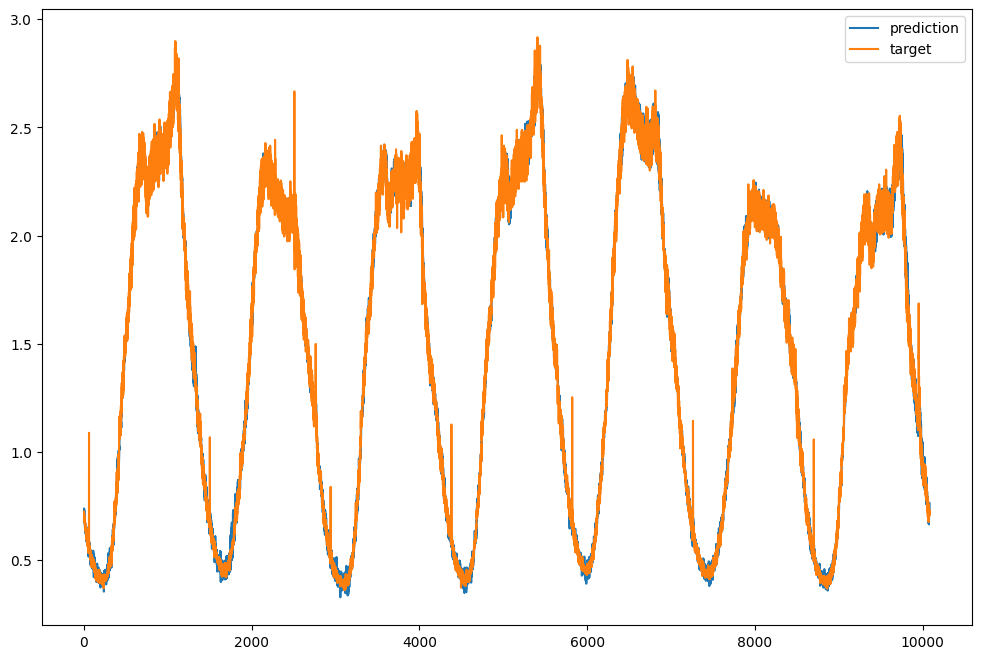

In [68]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [69]:
np.array(pred_list)

array([0.67576784, 0.73905635, 0.69690812, ..., 0.76591176, 0.7256844 ,
       0.72627079])

In [70]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.72416 ],
       [0.718512],
       [0.69116 ],
       ...,
       [0.736008],
       [0.705272],
       [0.728872]])

In [71]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [76]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

3.289588913321495 %


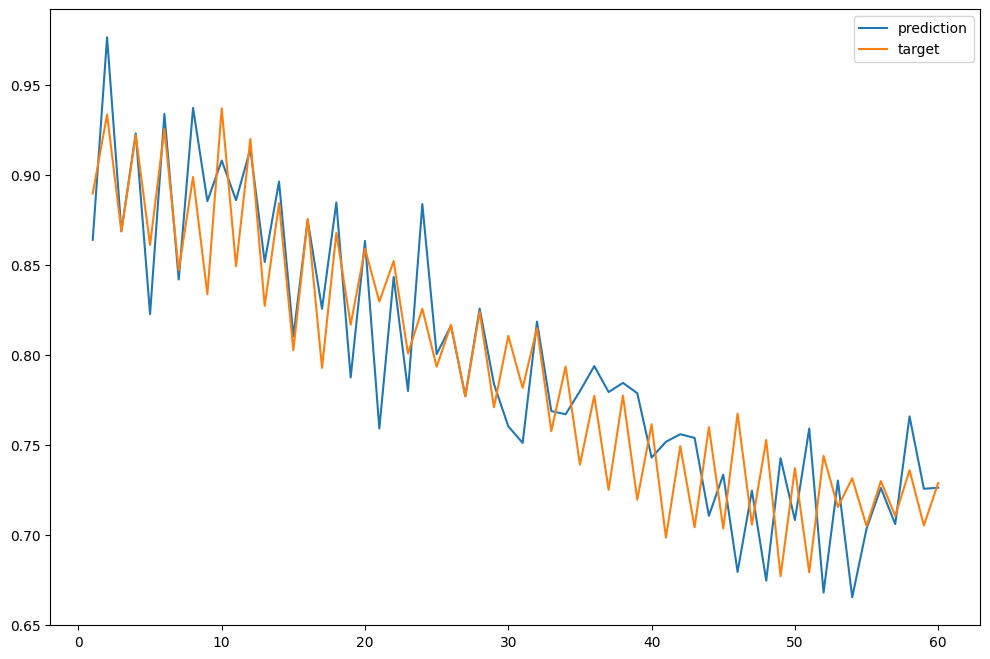

In [73]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [74]:
len(time_list)

10080

In [75]:
np.mean(time_list) 

0.28554514783715446

<font color = blue><font size = 6> Conclusion </font></font><br>
훈련을 하지 않았을때는 8퍼센트의 결과를 보였고 이해 비해서 0.3 퍼센트의 결과는 매우 좋은 결과이다 데이터의 의존성이 큰 DLinear,NLinear등은 이러한 결과가 변동성이 큰 데이터에서도 똑같이 적용될 것이라고 생각된다